In [24]:
import os
import time
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import json
from statsmodels.formula.api import ols
%matplotlib inline
import tushare as ts
from turtle import color
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression, f_regression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVR,SVR
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

from scipy.spatial.distance import pdist, squareform

In [25]:
def convert_suburb(df):
    suburb_lis = list(df['suburb'].unique())
    for i in range(1,len(suburb_lis)+1):
        df['suburb'] = df['suburb'].replace(suburb_lis[i-1],i)
    return df

In [26]:
# read in property data
property_data = pd.read_csv('../data/curated/data.csv')
property_data.shape

(13455, 119)

In [27]:
property_data.head()

,address,rent_weekly,floor,suburb,postcode,type,furnitured,pool,gym,num_bed,...,cloest_HELIPORT,cloest_AIRPORT,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance
0,1414/218-228 A'Beckett Street Melbourne VIC 3000,400,14,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,4602.243139,10572.425042,58968.064246,63924.811459,4924.342233,122.485883,37.427155,Flagstaff Railway Station (Melbourne City),41.4,282.0
1,11a/131 Lonsdale Sreet Melbourne VIC 3000,350,11,MELBOURNE,3000,Studio,1,0,0,1,...,5564.850055,11141.121440,59761.515319,63682.479322,5709.431207,195.490530,46.128039,Parliament Railway Station (Melbourne City),117.8,762.1
2,911/408 Lonsdale Street Melbourne VIC 3000,330,9,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,4821.362032,10953.719391,59069.898510,64077.037494,5011.485174,205.391048,21.831936,Melbourne Central Railway Station (Melbourne C...,69.9,515.3
3,918/422 Collins St Melbourne VIC 3000,600,9,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,4669.104831,11385.787890,58748.794039,64563.056533,4705.273027,36.919276,112.474189,Flagstaff Railway Station (Melbourne City),138.9,1103.0
4,602/118 Franklin Street Melbourne VIC 3000,330,6,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,4873.599965,10462.311621,59264.949130,63646.805335,5225.088718,168.187210,167.368064,Melbourne Central Railway Station (Melbourne C...,62.6,533.6


In [28]:
# drop the names (string)
property_data = property_data.drop(columns=['postcode'])
property_data = property_data.drop(columns=['cloest_train_station'])
property_data = property_data.drop(columns=['cloest_TRAIN_STATION'])
property_data = property_data.drop(columns=['address'])
property_data = property_data.drop(columns=['coordinates'])

property_data = property_data.replace(to_replace=r'Apartment \/ Unit \/ Flat \/ Penhouse', value=1, regex=True)
property_data = property_data.replace(to_replace=r'Studio', value=2, regex=True)
property_data = property_data.replace(to_replace=r'Townhouse', value=3, regex=True)
property_data = property_data.replace(to_replace=r'House', value=4, regex=True)
property_data['type'] = property_data['type'].astype('int')

# check dataset
property_data

,rent_weekly,floor,suburb,type,furnitured,pool,gym,num_bed,num_bath,num_car_park,...,cloest_GOLF COURSE,cloest_HELIPORT,cloest_AIRPORT,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance
0,400,14,MELBOURNE,1,0,0,0,1,1,0,...,6222.441683,4602.243139,10572.425042,58968.064246,63924.811459,4924.342233,122.485883,37.427155,41.4,282.0
1,350,11,MELBOURNE,2,1,0,0,1,1,0,...,7106.445738,5564.850055,11141.121440,59761.515319,63682.479322,5709.431207,195.490530,46.128039,117.8,762.1
2,330,9,MELBOURNE,1,0,0,0,1,1,0,...,6639.250058,4821.362032,10953.719391,59069.898510,64077.037494,5011.485174,205.391048,21.831936,69.9,515.3
3,600,9,MELBOURNE,1,0,0,0,2,1,0,...,6940.305653,4669.104831,11385.787890,58748.794039,64563.056533,4705.273027,36.919276,112.474189,138.9,1103.0
4,330,6,MELBOURNE,1,0,0,0,1,1,0,...,6243.470050,4873.599965,10462.311621,59264.949130,63646.805335,5225.088718,168.187210,167.368064,62.6,533.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13450,550,1,INVERLOCH,4,0,0,0,2,1,1,...,119551.399390,114739.370455,19432.079609,126198.772047,76148.979868,2434.006157,-1.000000,-1.000000,-1.0,-1.0
13451,550,1,INVERLOCH,4,1,0,0,4,2,0,...,119045.645193,114185.004327,21263.394445,124827.177483,77175.853309,540.604432,-1.000000,-1.000000,-1.0,-1.0
13452,440,1,INVERLOCH,4,0,0,0,2,1,0,...,119645.375833,114860.049711,18411.587767,126774.898267,75471.949785,3524.122065,-1.000000,-1.000000,-1.0,-1.0
13453,580,1,INVERLOCH,4,0,0,0,3,2,1,...,119544.858478,114744.013670,18990.553488,126399.975809,75830.887861,2888.754470,-1.000000,-1.000000,-1.0,-1.0


In [29]:
# read in predicted rental median price
predicted_rental_median_data = pd.read_csv('../data/curated/predict_rental_AutoReg.csv')
predicted_rental_median_data

,Mar_2000,Jun_2000,Sep_2000,Dec_2000,Mar_2001,Jun_2001,Sep_2001,Dec_2001,Mar_2002,Jun_2002,...,Dec_2025,Mar_2026,Jun_2026,Sep_2026,Dec_2026,Mar_2027,Jun_2027,Sep_2027,Dec_2027,suburb
0,175.0,180.0,180.0,180.0,180.0,185.0,190.0,195.0,200.0,200.0,...,472.206287,516.491418,474.643085,485.864002,503.440168,483.912978,488.385414,483.911503,484.547703,YARRAVILLE
1,145.0,145.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,155.0,...,328.045832,324.923760,334.097642,335.553168,336.187029,353.675407,331.858821,335.758787,345.086805,WODONGA
2,220.0,225.0,230.0,240.0,245.0,240.0,245.0,250.0,250.0,260.0,...,438.240129,445.039466,455.011112,461.676035,455.996250,450.615165,445.272220,429.647564,424.114145,WINDSOR
3,240.0,240.0,240.0,240.0,250.0,255.0,260.0,263.0,263.0,260.0,...,521.912354,513.685696,519.226838,530.134806,538.373845,530.141439,518.984886,510.934268,501.058677,WILLIAMSTOWN
4,150.0,150.0,155.0,170.0,163.0,170.0,165.0,170.0,175.0,180.0,...,389.291592,385.097303,378.192172,392.668803,401.616743,386.659778,392.091374,390.410736,389.379426,WHITTLESEA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,165.0,170.0,170.0,170.0,175.0,175.0,175.0,180.0,180.0,180.0,...,389.224616,405.742677,401.707094,410.379378,392.548879,400.250469,399.943881,398.669316,402.603799,ALTONA
209,150.0,146.0,150.0,155.0,160.0,165.0,165.0,170.0,175.0,180.0,...,446.551272,463.081245,452.227812,458.693335,444.162921,423.936817,418.731264,412.183752,404.822325,ALPHINGTON
210,130.0,135.0,135.0,135.0,140.0,140.0,140.0,150.0,150.0,155.0,...,336.300762,337.586171,330.403965,353.111456,334.664872,342.352293,344.650800,351.063770,358.018183,ALFREDTON
211,260.0,260.0,270.0,275.0,275.0,280.0,280.0,290.0,300.0,300.0,...,549.904660,546.836880,570.225829,592.002128,594.825665,565.493326,550.246053,532.124745,506.714078,ALBERT PARK


In [30]:
# pick up the predict rental median
predicted_median_list = predicted_rental_median_data.columns.tolist()[90:]
predicted_median_list
predicted_rental_median_data = predicted_rental_median_data[predicted_median_list]

# rename the predicted rental median and make them easy to see
name = [i[-8:] for i in predicted_rental_median_data.columns]
predicted_rental_median_data.columns = name

predicted_rental_median_data

,Sep_2022,Dec_2022,Mar_2023,Jun_2023,Sep_2023,Dec_2023,Mar_2024,Jun_2024,Sep_2024,Dec_2024,...,Dec_2025,Mar_2026,Jun_2026,Sep_2026,Dec_2026,Mar_2027,Jun_2027,Sep_2027,Dec_2027,suburb
0,428.894562,413.032741,413.772081,435.293222,425.079751,473.458118,429.807852,476.093541,461.635137,456.223369,...,472.206287,516.491418,474.643085,485.864002,503.440168,483.912978,488.385414,483.911503,484.547703,YARRAVILLE
1,296.323534,285.901825,298.505203,297.370081,286.888707,281.089415,294.445432,305.208869,302.067377,308.761536,...,328.045832,324.923760,334.097642,335.553168,336.187029,353.675407,331.858821,335.758787,345.086805,WODONGA
2,403.053060,396.230748,401.767353,395.915911,400.921754,403.038236,411.295578,426.736014,425.953232,432.192903,...,438.240129,445.039466,455.011112,461.676035,455.996250,450.615165,445.272220,429.647564,424.114145,WINDSOR
3,472.629426,473.275619,482.448550,481.036345,498.504757,498.547182,488.446425,479.559509,478.139881,505.453148,...,521.912354,513.685696,519.226838,530.134806,538.373845,530.141439,518.984886,510.934268,501.058677,WILLIAMSTOWN
4,339.847202,339.271662,346.187697,347.282248,344.234641,343.468491,348.796579,356.567462,366.995362,364.250388,...,389.291592,385.097303,378.192172,392.668803,401.616743,386.659778,392.091374,390.410736,389.379426,WHITTLESEA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,366.706809,369.844446,369.786326,375.366701,378.197996,381.163822,381.873196,391.505354,389.738146,399.275519,...,389.224616,405.742677,401.707094,410.379378,392.548879,400.250469,399.943881,398.669316,402.603799,ALTONA
209,374.577626,376.060972,353.414015,370.494813,375.453380,374.653765,395.549053,383.205485,404.482597,401.452697,...,446.551272,463.081245,452.227812,458.693335,444.162921,423.936817,418.731264,412.183752,404.822325,ALPHINGTON
210,292.042296,308.195601,282.322128,250.103589,293.211758,289.194831,308.337050,270.428207,282.587399,315.494346,...,336.300762,337.586171,330.403965,353.111456,334.664872,342.352293,344.650800,351.063770,358.018183,ALFREDTON
211,484.141889,509.172030,507.279307,529.246583,538.020772,539.945264,552.593092,487.218980,549.641926,534.473156,...,549.904660,546.836880,570.225829,592.002128,594.825665,565.493326,550.246053,532.124745,506.714078,ALBERT PARK


In [31]:
add_into_moedel_median_data = pd.DataFrame()
add_into_moedel_median_data['suburb'] = predicted_rental_median_data['suburb']
add_into_moedel_median_data['Sep_2022'] = predicted_rental_median_data['Sep_2022']
add_into_moedel_median_data.head()

,suburb,Sep_2022
0,YARRAVILLE,428.894562
1,WODONGA,296.323534
2,WINDSOR,403.053060
3,WILLIAMSTOWN,472.629426
4,WHITTLESEA,339.847202


In [32]:
property_data_copy = property_data.copy()
model_dataset = pd.merge(property_data_copy,add_into_moedel_median_data, \
                                on='suburb', how='left').fillna(0)
# clean features and convert string to numeric 
model_dataset = convert_suburb(model_dataset)
model_dataset

,rent_weekly,floor,suburb,type,furnitured,pool,gym,num_bed,num_bath,num_car_park,...,cloest_HELIPORT,cloest_AIRPORT,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance,Sep_2022
0,400,14,1,1,0,0,0,1,1,0,...,4602.243139,10572.425042,58968.064246,63924.811459,4924.342233,122.485883,37.427155,41.4,282.0,426.575597
1,350,11,1,2,1,0,0,1,1,0,...,5564.850055,11141.121440,59761.515319,63682.479322,5709.431207,195.490530,46.128039,117.8,762.1,426.575597
2,330,9,1,1,0,0,0,1,1,0,...,4821.362032,10953.719391,59069.898510,64077.037494,5011.485174,205.391048,21.831936,69.9,515.3,426.575597
3,600,9,1,1,0,0,0,2,1,0,...,4669.104831,11385.787890,58748.794039,64563.056533,4705.273027,36.919276,112.474189,138.9,1103.0,426.575597
4,330,6,1,1,0,0,0,1,1,0,...,4873.599965,10462.311621,59264.949130,63646.805335,5225.088718,168.187210,167.368064,62.6,533.6,426.575597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13450,550,1,570,4,0,0,0,2,1,1,...,114739.370455,19432.079609,126198.772047,76148.979868,2434.006157,-1.000000,-1.000000,-1.0,-1.0,0.000000
13451,550,1,570,4,1,0,0,4,2,0,...,114185.004327,21263.394445,124827.177483,77175.853309,540.604432,-1.000000,-1.000000,-1.0,-1.0,0.000000
13452,440,1,570,4,0,0,0,2,1,0,...,114860.049711,18411.587767,126774.898267,75471.949785,3524.122065,-1.000000,-1.000000,-1.0,-1.0,0.000000
13453,580,1,570,4,0,0,0,3,2,1,...,114744.013670,18990.553488,126399.975809,75830.887861,2888.754470,-1.000000,-1.000000,-1.0,-1.0,0.000000


In [33]:
x_col_name = []
for i in model_dataset.columns:
    if i != 'rent_weekly':
        x_col_name.append(i)
x_col_name

['floor',
 'suburb',
 'type',
 'furnitured',
 'pool',
 'gym',
 'num_bed',
 'num_bath',
 'num_car_park',
 'SECONDARY SCHOOL',
 'PRIMARY AND SECONDARY SCHOOL',
 'PRIMARY SCHOOL',
 'SHOPPING CENTRE',
 'PARK',
 'KINDERGARTEN',
 'POST OFFICE',
 'SPECIAL SCHOOL',
 'CHILD CARE',
 'BAR',
 'SPORTS COMPLEX',
 'EDUCATION COMPLEX',
 'CEMETERY',
 'LIBRARY',
 'UNIVERSITY',
 'GENERAL HOSPITAL',
 'POLICE STATION',
 'FURTHER EDUCATION',
 'PLAYGROUND',
 'PLANTATION',
 'WINERY',
 'FARM',
 'VINEYARD',
 'TENNIS COURT',
 'BAY',
 'PIER',
 'SWIMMING POOL',
 'ART GALLERY',
 'HARBOUR',
 'COMMUNITY HEALTH CENTRE',
 'MARKET',
 'PRISON',
 'BOTANIC GARDENS',
 'SPECIALISED HOSPITAL',
 'BANK',
 'AGED CARE',
 'SURFING SPOT',
 'COAST',
 'GOLF COURSE',
 'HELIPORT',
 'AIRPORT',
 'IRON ORE PROCESSOR',
 'MILL/TIMBER OPERATIONS',
 'BEACH',
 'TRAIN STATION',
 'TRAM STATION',
 'BUS',
 'Education',
 'Commercial',
 'Environment',
 'Medication',
 'Secrity',
 'Industrial',
 'Prison',
 'Transportation',
 'cloest_SECONDARY SCHOOL',

In [34]:
train_y = model_dataset['rent_weekly']
train_x = model_dataset[x_col_name]

In [35]:
# try random forest regressor

%time
rf = RandomForestRegressor(n_estimators = 400, max_features = 'sqrt', max_depth = 5, random_state = 50)
rf.fit(train_x, train_y)
pred = rf.predict(train_x)
mse = mean_squared_error(train_y, pred)
rmse = mse**.5
print('The mse is : ', mse)
print('The rmse is : ', rmse)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
The mse is :  13524.282197619283
The rmse is :  116.2939473817072


In [36]:
# try random forest regressor

%time
rf = RandomForestRegressor(n_estimators = 400, max_features = 'sqrt', max_depth = 50, random_state = 50)
rf.fit(train_x, train_y)
pred = rf.predict(train_x)
mse = mean_squared_error(train_y, pred)
rmse = mse**.5
print('The mse is : ', mse)
print('The rmse is : ', rmse)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.29 µs
The mse is :  2223.1906239318023
The rmse is :  47.15072241155805


In [37]:
# best model for now
%time
rf = RandomForestRegressor(n_estimators = 350, max_features = 'sqrt', max_depth = 50, random_state = 50)
rf.fit(train_x, train_y)
pred = rf.predict(train_x)
mse = mean_squared_error(train_y, pred)
rmse = mse**.5
print('The mse is : ', mse)
print('The rmse is : ', rmse)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
The mse is :  2225.70408476893
The rmse is :  47.17736835357532


In [38]:
predict_year_list = predicted_rental_median_data.columns[:-1].tolist()
predict_year_list

['Sep_2022',
 'Dec_2022',
 'Mar_2023',
 'Jun_2023',
 'Sep_2023',
 'Dec_2023',
 'Mar_2024',
 'Jun_2024',
 'Sep_2024',
 'Dec_2024',
 'Mar_2025',
 'Jun_2025',
 'Sep_2025',
 'Dec_2025',
 'Mar_2026',
 'Jun_2026',
 'Sep_2026',
 'Dec_2026',
 'Mar_2027',
 'Jun_2027',
 'Sep_2027',
 'Dec_2027']

In [39]:
model_dataset

,rent_weekly,floor,suburb,type,furnitured,pool,gym,num_bed,num_bath,num_car_park,...,cloest_HELIPORT,cloest_AIRPORT,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance,Sep_2022
0,400,14,1,1,0,0,0,1,1,0,...,4602.243139,10572.425042,58968.064246,63924.811459,4924.342233,122.485883,37.427155,41.4,282.0,426.575597
1,350,11,1,2,1,0,0,1,1,0,...,5564.850055,11141.121440,59761.515319,63682.479322,5709.431207,195.490530,46.128039,117.8,762.1,426.575597
2,330,9,1,1,0,0,0,1,1,0,...,4821.362032,10953.719391,59069.898510,64077.037494,5011.485174,205.391048,21.831936,69.9,515.3,426.575597
3,600,9,1,1,0,0,0,2,1,0,...,4669.104831,11385.787890,58748.794039,64563.056533,4705.273027,36.919276,112.474189,138.9,1103.0,426.575597
4,330,6,1,1,0,0,0,1,1,0,...,4873.599965,10462.311621,59264.949130,63646.805335,5225.088718,168.187210,167.368064,62.6,533.6,426.575597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13450,550,1,570,4,0,0,0,2,1,1,...,114739.370455,19432.079609,126198.772047,76148.979868,2434.006157,-1.000000,-1.000000,-1.0,-1.0,0.000000
13451,550,1,570,4,1,0,0,4,2,0,...,114185.004327,21263.394445,124827.177483,77175.853309,540.604432,-1.000000,-1.000000,-1.0,-1.0,0.000000
13452,440,1,570,4,0,0,0,2,1,0,...,114860.049711,18411.587767,126774.898267,75471.949785,3524.122065,-1.000000,-1.000000,-1.0,-1.0,0.000000
13453,580,1,570,4,0,0,0,3,2,1,...,114744.013670,18990.553488,126399.975809,75830.887861,2888.754470,-1.000000,-1.000000,-1.0,-1.0,0.000000


In [40]:
save_original_rent_weekly = model_dataset['rent_weekly'].tolist()

In [41]:
# Train = model_dataset.copy()
# Train = Train.rename(columns={'Sep_2022':'loop_future_timeline'})
# Train

In [42]:
# Train = model_dataset.copy()
# Train = Train.rename(columns={'Sep_2022':'loop_future_timeline'})

# train_Y = pd.DataFrame()
# train_Y['rent_weekly'] = Train['rent_weekly']

# train_X = pd.DataFrame()
# train_X = Train.drop(columns = 'rent_weekly')
# # train_X['loop_future_timeline']
# train_X

In [43]:
# Train = model_dataset.copy()
# Train = Train.rename(columns={'Sep_2022':'loop_future_timeline'})

# train_Y = pd.DataFrame()
# train_Y['rent_weekly'] = Train['rent_weekly']

# train_X = pd.DataFrame()
# train_X = Train.drop(columns = 'rent_weekly')

final_predict_year = 22
predict_result_df = pd.DataFrame()

count = 1
for future_year in predict_year_list:
    print(future_year)
    # train_Y
    # train_X
    add_into_moedel_median_data = pd.DataFrame()
    add_into_moedel_median_data['suburb'] = predicted_rental_median_data['suburb']
    add_into_moedel_median_data[future_year] = predicted_rental_median_data[future_year]

    model_dataset = pd.merge(property_data_copy,add_into_moedel_median_data,\
                                            on='suburb', how='left').fillna(0)
    model_dataset = convert_suburb(model_dataset)

    model_dataset = model_dataset.rename(columns={'Sep_2022':'loop_future_timeline'})

    train_Y = pd.DataFrame()
    train_Y['rent_weekly'] = model_dataset['rent_weekly']

    train_X = pd.DataFrame()
    train_X = model_dataset.drop(columns = 'rent_weekly')

    rf = RandomForestRegressor(n_estimators = 350, max_features = 'sqrt', max_depth = 50, random_state = 50)
    rf.fit(train_X, train_Y['rent_weekly'])
    pred = rf.predict(train_X)
    
    predict_result_df[future_year] = pred

    train_Y['rent_weekly'] = pred
    train_X['loop_future_timeline'] = predicted_rental_median_data[\
                                        predicted_rental_median_data.columns[count]]

    if count == final_predict_year:
        break

predict_result_df

Sep_2022
Dec_2022
Mar_2023
Jun_2023
Sep_2023
Dec_2023
Mar_2024
Jun_2024
Sep_2024
Dec_2024
Mar_2025
Jun_2025
Sep_2025
Dec_2025
Mar_2026
Jun_2026
Sep_2026
Dec_2026
Mar_2027
Jun_2027
Sep_2027
Dec_2027


,Sep_2022,Dec_2022,Mar_2023,Jun_2023,Sep_2023,Dec_2023,Mar_2024,Jun_2024,Sep_2024,Dec_2024,...,Sep_2025,Dec_2025,Mar_2026,Jun_2026,Sep_2026,Dec_2026,Mar_2027,Jun_2027,Sep_2027,Dec_2027
0,481.800000,479.500000,479.985714,480.300000,479.171429,478.385714,476.942857,482.128571,478.557143,477.200000,...,478.714286,478.228571,476.371429,481.971429,478.328571,477.728571,483.914286,478.014286,481.314286,482.771429
1,426.257143,426.514286,423.657143,426.114286,427.942857,428.128571,426.671429,427.700000,422.714286,422.685714,...,426.057143,429.400000,427.528571,423.642857,424.342857,425.728571,424.885714,425.971429,427.828571,427.642857
2,410.528571,410.154286,408.185714,408.414286,408.771429,409.528571,409.585714,408.985714,409.385714,409.014286,...,410.328571,411.128571,412.085714,410.342857,410.242857,411.071429,409.600000,409.271429,410.414286,408.242857
3,561.471429,560.542857,561.142857,559.557143,560.157143,561.400000,560.800000,558.485714,561.385714,561.400000,...,559.214286,560.314286,557.914286,560.300000,560.271429,560.242857,559.690683,561.471429,560.985714,558.600000
4,389.461905,389.442857,389.104762,392.247619,388.685714,390.642857,388.914286,389.385714,388.776190,391.376190,...,389.785714,390.261905,389.885714,389.861905,391.400000,390.342857,389.419048,388.214286,388.428571,390.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13450,523.514286,524.414286,528.385714,524.614286,526.114286,526.771429,528.957143,528.657143,526.228571,526.628571,...,524.342857,525.700000,527.228571,529.385714,527.742857,530.257143,531.171429,527.785714,531.628571,529.600000
13451,515.685714,520.242857,519.942857,519.114286,519.342857,515.314286,519.471429,517.900000,518.442857,518.571429,...,517.714286,518.500000,515.900000,520.257143,517.771429,517.957143,517.700000,516.442857,518.257143,516.171429
13452,446.771429,449.785714,447.642857,452.814286,448.300000,450.485714,449.257143,449.100000,446.957143,448.614286,...,449.385714,447.814286,448.171429,447.328571,448.328571,451.100000,447.228571,448.042857,443.400000,448.357143
13453,560.800000,558.271429,558.514286,559.628571,562.671429,558.185714,558.385714,558.400000,558.842857,557.842857,...,556.771429,559.128571,556.100000,560.871429,560.871429,556.814286,555.885714,559.057143,557.985714,557.585714


In [44]:
result_df = predict_result_df.copy()

In [45]:
result_df.insert(0,'current_rent_weekly',property_data['rent_weekly'])
result_df

,current_rent_weekly,Sep_2022,Dec_2022,Mar_2023,Jun_2023,Sep_2023,Dec_2023,Mar_2024,Jun_2024,Sep_2024,...,Sep_2025,Dec_2025,Mar_2026,Jun_2026,Sep_2026,Dec_2026,Mar_2027,Jun_2027,Sep_2027,Dec_2027
0,400,481.800000,479.500000,479.985714,480.300000,479.171429,478.385714,476.942857,482.128571,478.557143,...,478.714286,478.228571,476.371429,481.971429,478.328571,477.728571,483.914286,478.014286,481.314286,482.771429
1,350,426.257143,426.514286,423.657143,426.114286,427.942857,428.128571,426.671429,427.700000,422.714286,...,426.057143,429.400000,427.528571,423.642857,424.342857,425.728571,424.885714,425.971429,427.828571,427.642857
2,330,410.528571,410.154286,408.185714,408.414286,408.771429,409.528571,409.585714,408.985714,409.385714,...,410.328571,411.128571,412.085714,410.342857,410.242857,411.071429,409.600000,409.271429,410.414286,408.242857
3,600,561.471429,560.542857,561.142857,559.557143,560.157143,561.400000,560.800000,558.485714,561.385714,...,559.214286,560.314286,557.914286,560.300000,560.271429,560.242857,559.690683,561.471429,560.985714,558.600000
4,330,389.461905,389.442857,389.104762,392.247619,388.685714,390.642857,388.914286,389.385714,388.776190,...,389.785714,390.261905,389.885714,389.861905,391.400000,390.342857,389.419048,388.214286,388.428571,390.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13450,550,523.514286,524.414286,528.385714,524.614286,526.114286,526.771429,528.957143,528.657143,526.228571,...,524.342857,525.700000,527.228571,529.385714,527.742857,530.257143,531.171429,527.785714,531.628571,529.600000
13451,550,515.685714,520.242857,519.942857,519.114286,519.342857,515.314286,519.471429,517.900000,518.442857,...,517.714286,518.500000,515.900000,520.257143,517.771429,517.957143,517.700000,516.442857,518.257143,516.171429
13452,440,446.771429,449.785714,447.642857,452.814286,448.300000,450.485714,449.257143,449.100000,446.957143,...,449.385714,447.814286,448.171429,447.328571,448.328571,451.100000,447.228571,448.042857,443.400000,448.357143
13453,580,560.800000,558.271429,558.514286,559.628571,562.671429,558.185714,558.385714,558.400000,558.842857,...,556.771429,559.128571,556.100000,560.871429,560.871429,556.814286,555.885714,559.057143,557.985714,557.585714


In [46]:
result_df.loc[0].tolist()

[400.0,
 481.8,
 479.5,
 479.98571428571427,
 480.3,
 479.1714285714286,
 478.3857142857143,
 476.9428571428571,
 482.12857142857143,
 478.5571428571429,
 477.2,
 480.4142857142857,
 477.4,
 478.7142857142857,
 478.22857142857146,
 476.37142857142857,
 481.9714285714286,
 478.3285714285714,
 477.72857142857146,
 483.9142857142857,
 478.01428571428573,
 481.3142857142857,
 482.77142857142854]

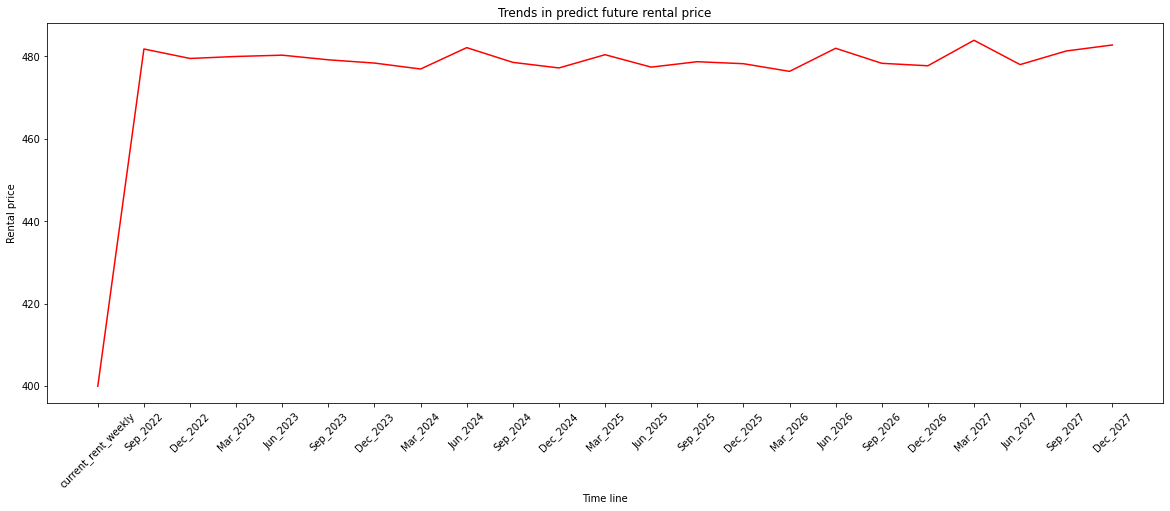

In [47]:
plt.figure(figsize=(20,7))
plt.xticks(rotation=45)
plt.ylabel("Rental price")
plt.xlabel("Time line")
plt.title("Trends in predict future rental price")
plt.plot(result_df.columns.tolist(),result_df.loc[0].tolist(), color = 'r')

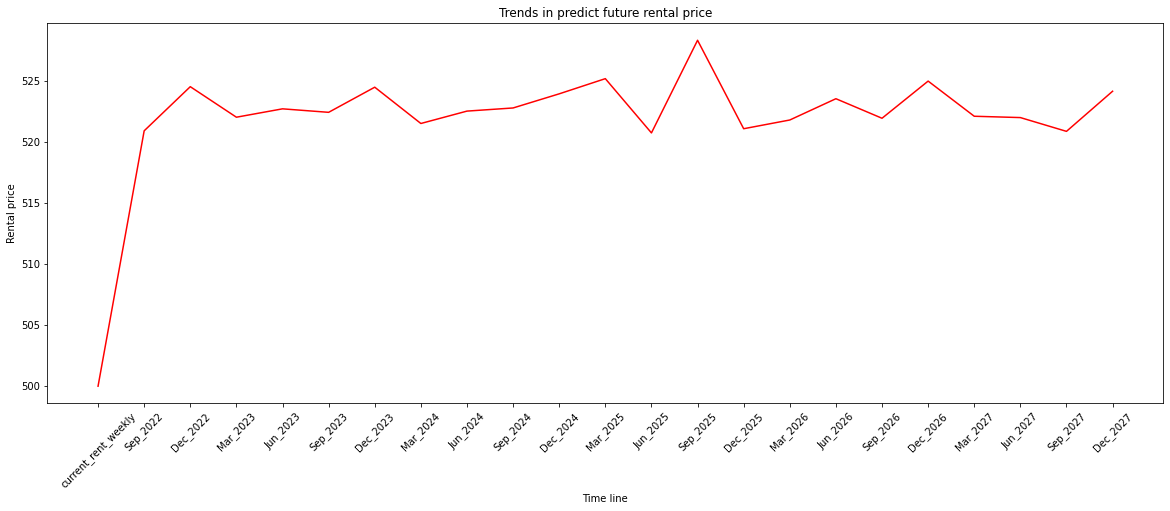

In [49]:
plt.figure(figsize=(20,7))
plt.xticks(rotation=45)
plt.ylabel("Rental price")
plt.xlabel("Time line")
plt.title("Trends in predict future rental price")
plt.plot(result_df.columns.tolist(),result_df.loc[800].tolist(), color = 'r')

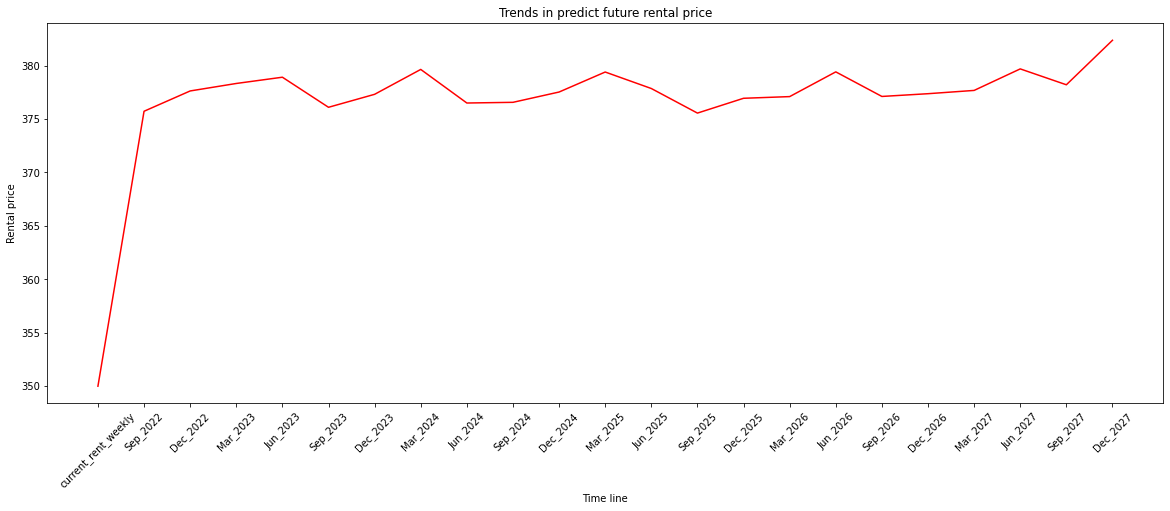

In [50]:
plt.figure(figsize=(20,7))
plt.xticks(rotation=45)
plt.ylabel("Rental price")
plt.xlabel("Time line")
plt.title("Trends in predict future rental price")
plt.plot(result_df.columns.tolist(),result_df.loc[10].tolist(), color = 'r')